In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils.paths import DATA_RAW_DIR

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor

In [2]:
path_partidos = str(DATA_RAW_DIR / 'partidos_cebollitas.csv')

print('Path:', path_partidos)
print('Does path exist?', Path(path_partidos).exists())

Path: /Users/jssdev/Dev/Learning/Platzi/platzi-machine-learning/data/raw/partidos_cebollitas.csv
Does path exist? True


In [3]:
df_partidos = pd.read_csv(path_partidos, sep=',', encoding='utf-8')
df_partidos.head()

,fecha_partido,equipo_local,equipo_visitante,goles_local,goles_visitante,posesion_local (%),posesion_visitante (%),tiros_arco_local,tiros_arco_visitante,estadio
0,2023-01-01,Atlético Python,Cebollitas FC,2,0,54,46,12,6,Python Arena
1,2023-01-08,NumPy City,Atlético Python,1,5,60,40,12,3,Estadio ML
2,2023-01-15,Cebollitas FC,Data United,1,0,55,45,10,7,Python Arena
3,2023-01-22,Atlético Python,Data United,2,3,57,43,3,3,Campo Pandas
4,2023-01-29,Data United,Cebollitas FC,5,3,52,48,7,12,Estadio ML


In [4]:
df_partidos['diferencia_goles'] = df_partidos['goles_local'] - df_partidos['goles_visitante']

In [5]:
df_partidos['ratio_tiros_posesion_local'] = df_partidos['tiros_arco_local'] / df_partidos['posesion_local (%)']

In [6]:
df_partidos.head()

,fecha_partido,equipo_local,equipo_visitante,goles_local,goles_visitante,posesion_local (%),posesion_visitante (%),tiros_arco_local,tiros_arco_visitante,estadio,diferencia_goles,ratio_tiros_posesion_local
0,2023-01-01,Atlético Python,Cebollitas FC,2,0,54,46,12,6,Python Arena,2,0.222222
1,2023-01-08,NumPy City,Atlético Python,1,5,60,40,12,3,Estadio ML,-4,0.200000
2,2023-01-15,Cebollitas FC,Data United,1,0,55,45,10,7,Python Arena,1,0.181818
3,2023-01-22,Atlético Python,Data United,2,3,57,43,3,3,Campo Pandas,-1,0.052632
4,2023-01-29,Data United,Cebollitas FC,5,3,52,48,7,12,Estadio ML,2,0.134615


**Modelo utilizado**: `SelectKBest` con la función de puntuación `f_regression` (ANOVA F-test)

**¿Por qué este modelo?**  
- `f_regression` realiza **regresiones univariantes** entre cada predictor y la variable objetivo, calculando el estadístico F que mide la fuerza de la relación lineal.  
- Es un **método de filtro** rápido y sencillo para identificar qué variables tienen mayor capacidad explicativa antes de ajustar un modelo más complejo.  

1. **Definir X e y**  
2. **Crear `SelectKBest(score_func=f_regression, k=2)`**  
3. **Ajustar el selector**  
4. **Extraer puntuaciones**  
5. **Ordenar en un DataFrame**  


In [9]:
X =df_partidos[['posesion_local (%)', 'tiros_arco_local', 'ratio_tiros_posesion_local']]
y = df_partidos['goles_local']

print('Shape X:', X.shape)
print('Shape y:', y.shape)

Shape X: (100, 3)
Shape y: (100,)


In [13]:
f_regression

<function sklearn.feature_selection._univariate_selection.f_regression(X, y, *, center=True, force_finite=True)>

In [15]:
# Seleccionar las 2 mejores variables
selector = SelectKBest(score_func=f_regression, k=2)
selector.fit(X, y)

SelectKBest(k=2, score_func=<function f_regression at 0x16833f9c0>)

In [16]:
selector

SelectKBest(k=2, score_func=<function f_regression at 0x16833f9c0>)

In [17]:
# Resultados ordenados por relevancia
scores = selector.scores_
scores

array([2.84415913, 1.37269131, 2.32332002])

In [18]:
variables = X.columns
variables

Index(['posesion_local (%)', 'tiros_arco_local', 'ratio_tiros_posesion_local'], dtype='object')

In [19]:
resultados = pd.DataFrame({'Variable': variables, 'Score': scores}).sort_values(by='Score', ascending=False)
resultados

,Variable,Score
0,posesion_local (%),2.844159
2,ratio_tiros_posesion_local,2.323320
1,tiros_arco_local,1.372691


**Modelo utilizado**: `DecisionTreeRegressor`  
**¿Por qué este modelo?**  
Un árbol de regresión es un método basado en divisiones sucesivas que mide la **importancia de cada variable** según cuánto reduce la impureza (error) del árbol en cada nodo.

* Crear y entrenar el modelo
* Obtener importancias de las variables
* Organizar resultados en un DataFrame



In [21]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [22]:
decision_tree_model

DecisionTreeRegressor(random_state=42)

In [24]:
# Importancia calculada por el modelo
importancia = decision_tree_model.feature_importances_
importancia

array([0.49156261, 0.20268268, 0.30575471])

In [25]:
resultado_importancia = pd.DataFrame({
    'Variable': variables, 
    'Importancia': importancia
}).sort_values(by='Importancia', ascending=False)

resultado_importancia

,Variable,Importancia
0,posesion_local (%),0.491563
2,ratio_tiros_posesion_local,0.305755
1,tiros_arco_local,0.202683


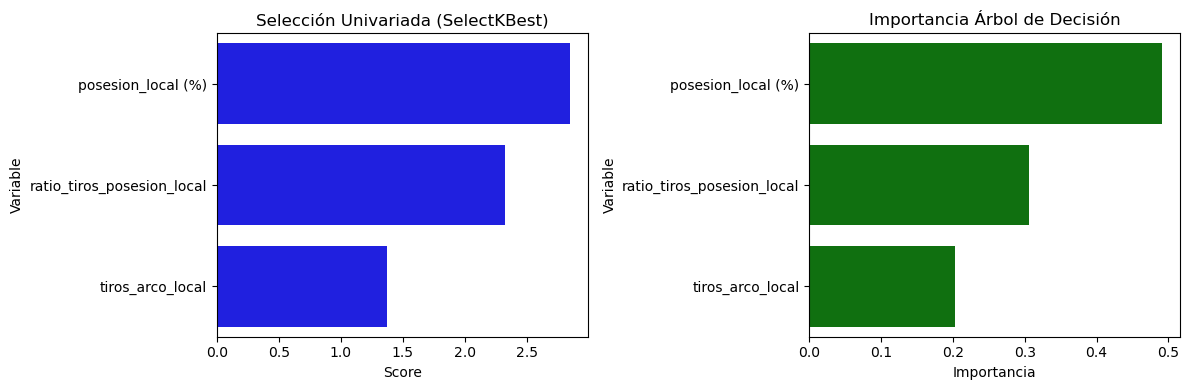

In [30]:
# Gráficas de resultados
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Gráfica SelectKBest (análisis univariado)
sns.barplot(x='Score', y='Variable', data=resultados, ax=ax[0], color='blue')
ax[0].set_title('Selección Univariada (SelectKBest)')

# Gráfica Importancia (árbol decisión)
sns.barplot(x='Importancia', y='Variable', data=resultado_importancia, ax=ax[1], color='green')
ax[1].set_title('Importancia Árbol de Decisión')

plt.tight_layout()
plt.show()